In [1]:
# For Colab
import os
os.chdir('/content/drive/Othercomputers/AKATSUKI-PC/PycharmProjects/pluseleven')

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from all_legacy_code.src.preprocess import text_prep
from all_legacy_code.src.preprocess import image_prep
from all_legacy_code.src import models

In [2]:
os.chdir('C:\\Users\\thory\\PycharmProjects\\pluseleven')

In [3]:
DATA_HOME = 'resources/age_gender/UTKFace/UTKFace'

In [4]:
gender_label = {0: 'Male', 1: 'Female'}
ethnicity_label = {
    0: 'European Descent',
    1: 'African Descent',
    2: 'East Asian Descent',
    3: 'South Asian Descent',
    4: 'Diverse/Mixed or Other Ethnicities'
}

In [22]:
# Use the function
dataset = image_prep.preprocess_for_training(DATA_HOME, batch_size=32, shuffle_buffer_size=10000)

In [23]:
dataset.save('resources/age_gender/data/dataset')

28.0 1 [0. 0. 0. 0. 1.]


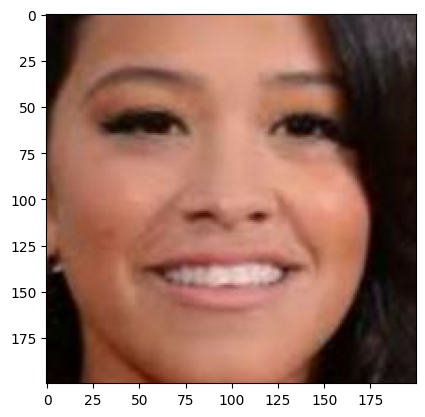

In [9]:
# Example to iterate over the dataset
for image, (age, gender, race) in dataset.take(1):
    print(age[0].numpy(), gender[0].numpy(), race[0].numpy())
    plt.imshow(image[0])
    plt.show()

In [5]:
dataset = tf.data.Dataset.load('resources/age_gender/data/dataset')

In [4]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()
dataset_size

741

In [5]:
train_dataset = dataset.take(541)
val_dataset = dataset.skip(541).take(100)
test_dataset = dataset.skip(641)

In [7]:
model_2 = models.create_cnn_model(compile=True)

In [6]:
model_2 = keras.models.load_model('resources/age_gender/saved/age_gender_best_yet.h5')

In [9]:
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 198, 198, 32)         896       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 198, 198, 32)         128       ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 99, 99, 32)           0         ['batch_normalization_3[

In [7]:
es_callback = keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)
# tb_callback = keras.callbacks.TensorBoard(log_dir='tb_logs')
cp_callback = keras.callbacks.ModelCheckpoint('resources/age_gender/saved/age_gender_last_try.h5', save_best_only=True)

In [10]:
dataset

<_LoadDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)))>

In [8]:
max_lr = 0.00001  # Peak learning rate
num_epochs = 13
batch_size = 32
num_samples = 541*32

# Initialize the scheduler
onecycle_lr_scheduler = text_prep.OneCycleLRSchedule(max_lr, total_steps=num_epochs * (num_samples // batch_size), lr_start=0.000001, lr_end=0.000001)

In [11]:
optimizer = keras.optimizers.Nadam(learning_rate=0.00000005)
loss_weights = {'age_output': 0.01,
                        'gender_output': 1.0,
                        'race_output': 1.0}
model_2.compile(optimizer=optimizer,
                      loss={'age_output': 'mse',
                            'gender_output': 'binary_crossentropy',
                            'race_output': 'categorical_crossentropy'},
                      loss_weights=loss_weights,
                      metrics={'age_output': ['mae'],
                               'gender_output': ['accuracy'],
                               'race_output': ['accuracy']})

In [ ]:
history1 = model_2.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=[es_callback, cp_callback])

Epoch 1/20
541/541 [==============================] - 74s 128ms/step - loss: 0.9622 - age_output_loss: 70.8231 - gender_output_loss: 0.0277 - race_output_loss: 0.2263 - age_output_mae: 6.3501 - gender_output_accuracy: 0.9902 - race_output_accuracy: 0.9120 - val_loss: 3.1712 - val_age_output_loss: 83.6447 - val_gender_output_loss: 0.7544 - val_race_output_loss: 1.5804 - val_age_output_mae: 6.5770 - val_gender_output_accuracy: 0.8759 - val_race_output_accuracy: 0.7694
Epoch 2/20
541/541 [==============================] - 69s 126ms/step - loss: 0.9591 - age_output_loss: 71.4691 - gender_output_loss: 0.0283 - race_output_loss: 0.2161 - age_output_mae: 6.3587 - gender_output_accuracy: 0.9896 - race_output_accuracy: 0.9158 - val_loss: 3.1721 - val_age_output_loss: 83.6449 - val_gender_output_loss: 0.7547 - val_race_output_loss: 1.5810 - val_age_output_mae: 6.5770 - val_gender_output_accuracy: 0.8756 - val_race_output_accuracy: 0.7691
Epoch 3/20
541/541 [==============================] - 70s 

In [15]:
results = model_2.evaluate(test_dataset)
print(f'\nAge MAE: {round(results[-3],1)} years, \nGender Accuracy: {round(results[-2]*100,2)} %\nEthnicity Accuracy: {round(results[-1] *100, 2)} %')


Age MAE: 6.5 years, 
Gender Accuracy: 87.42 %
Ethnicity Accuracy: 78.79 %


In [16]:
model_2.save('resources/age_gender/saved/age_gender_best_yet.keras')

In [4]:
model_2 = keras.models.load_model('resources/age_gender/saved/age_gender_best_yet.h5')

In [3]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [91]:
def predict_age_gender_race(frame, model):
    prepped_frame = image_prep.preprocess_for_prediction(frame)
    age ,gender, race = model.predict(prepped_frame)
    age, gender, race = np.round(age[0][0],2), int(np.round(gender[0][0])), np.argmax(race[0], axis=-1)
    return age, gender, race

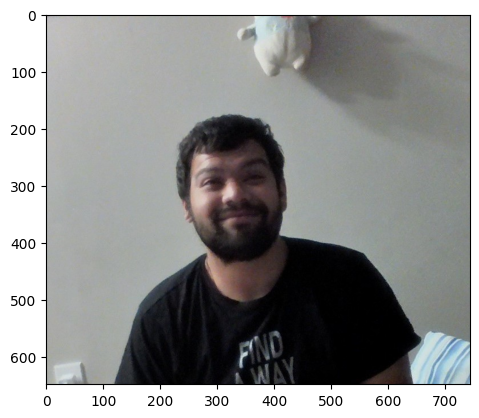

In [104]:
my_image = plt.imread('resources/temp_faces/Nand.jpg')
plt.imshow(my_image)

In [105]:
predict_age_gender_race(my_image, model_2)

1/1 [==============================] - 0s 58ms/step


(32.24, 0, 1)